In [3]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
import math
import itertools
from collections import defaultdict
from operator import itemgetter

import torch
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import normalize
from torch import nn
from torch.nn import functional as F
from tqdm.notebook import tqdm

from phoneme_lm import PhonemeLM, build_data_loader, build_vocab, encode_pronunciation
from utils import load_data, split_data

In [5]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

## Training the Model ##

In [6]:
df = load_data(True)
len(df)

124996

In [7]:
phoneme_to_idx, idx_to_phoneme = build_vocab(df.pronunciation.values)
df['phoneme_ids'] = df.pronunciation.apply(lambda pronunciation: encode_pronunciation(pronunciation, phoneme_to_idx))

In [8]:
df['pronunciation_string'] = df.pronunciation.apply(' '.join)
df['length'] = df.pronunciation.apply(len)

In [9]:
train_df, dev_df, test_df = split_data(df, dev_proportion=.2, test_proportion=.01)

In [10]:
len(train_df), len(dev_df), len(test_df)

(98746, 25000, 1250)

In [ ]:
PhonemeLM?

In [11]:
%%time

lm = PhonemeLM(phoneme_to_idx, idx_to_phoneme, 'gru', embedding_dimension=10, rnn_hidden_dimension=20, device='cpu')
train_losses, dev_losses = lm.fit(train_df.pronunciation, dev_df.pronunciation, epochs=2)

Epoch 1: train loss: 0.7901009	assess loss: 1.2101
	 V <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
	 N OW2 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
	 ER2 L <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
	 IH1 <PAD>
	 
Epoch 2: train loss: 0.7126012	assess loss: 1.0998
	 T T
	 P M
	 D R AA1
	 S EY1 F N P R N
	 OW2 N
CPU times: user 9min 13s, sys: 37.6 s, total: 9min 51s
Wall time: 1min 53s


In [24]:
param_grid = ParameterGrid({
    'rnn_type': ['gru'],
    'embedding_dimension': [10, 50, 100, 200],
    'rnn_hidden_dimension': [50, 100, 200, 400],
})


records = []
for params in tqdm(param_grid):
    lm = PhonemeLM(phoneme_to_idx, idx_to_phoneme, batch_size=1024,  epochs=30, **params)
    print('Model Params:', params)
    train_losses, dev_losses = lm.fit(train_df.pronunciation, dev_df.pronunciation)
    for epoch, (train_loss, dev_loss) in enumerate(zip(train_losses, dev_losses), start=1):
        record = params.copy()
        record['epoch'] = epoch
        record['train_loss'] = train_loss
        record['dev_loss'] = dev_loss
    
        records.append(record)

models_df = pd.DataFrame.from_records(records)

/Users/colin/code/sonorous/venv/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Epoch 1: train loss: 3.40128	assess loss: 3.5402
	 IY2 HH Z ER2 AE0 HH AY1 UH2 AA0 Z
	 B ER2 AH1 OW1 M AY2 AH2 EH1 AW1 Y
	 D EY0 TH B HH B T JH AA0 M
	 DH
	 EH2 DH CH IY0 UH2 OY0 TH IH1 S AH0
Epoch 2: train loss: 2.42981	assess loss: 2.7086
	 OY0 AA1 AH2 Z AO0 OW1 AH0 M DH Z
	 OY0 UH0 EH1 ER0 R UH1 EH0 ER2 ER0 OY0
	 AE2 AH1 IY2 N IH1 D Y OY1 OW2 B
	 AW1 ER0 T ER2 AE1 JH AE2 F M OW2
	 DH EH2 UH0 UH0 UW0 HH CH AH1 HH AO1
Epoch 1: train loss: 0.99515	assess loss: 1.5116
	 M OW1 IY1 ER0 M ZH <PAD>
	 R AA0 ER2 B B <PAD> <PAD> <PAD> <PAD> <PAD>
	 B AH1 AY0 AY1 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
	 AH1 HH D <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
	 AO0 IH2 EY0 <PAD> TH <PAD> <PAD> <PAD> <PAD> <PAD>
Epoch 2: train loss: 0.83200	assess loss: 1.2769
	 IY1 EY0 AW2 R N
	 L EH0 CH UH1 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
	 AO2 D G Z JH K L <PAD> <PAD> <PAD>
	 <PAD>
	 IH0 K



In [26]:
models_df

,embedding_dimension,rnn_hidden_dimension,rnn_type,epoch,train_loss,dev_loss
0,5,5,gru,0,3.401155,3.540207
1,5,5,gru,1,2.429774,2.708627
2,5,50,gru,0,0.995100,1.511566
3,5,50,gru,1,0.831986,1.276939


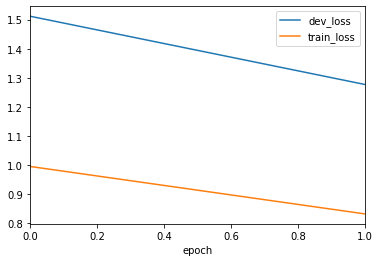

In [43]:
models_df[(models_df.rnn_hidden_dimension == 50)].set_index('epoch').dev_loss.plot()
models_df[(models_df.rnn_hidden_dimension == 50)].set_index('epoch').train_loss.plot()
plt.legend()

In [ ]:
models_df.sort_values('dev_loss')

In [ ]:
models_df.corrwith(models_df.dev_loss)

In [ ]:
%%time

lm = PhonemeLM(
    phoneme_to_idx, idx_to_phoneme, device='cuda',
    rnn_type='gru', embedding_dimension=100, rnn_hidden_dimension=200,
    batch_size=1024, epochs=100
)

lm.fit(train_df.pronunciation, dev_df.pronunciation)

## Probability of Real Words ##

In [ ]:
%%time

df['probability'] = df.pronunciation.apply(lambda pronunciation: lm.calculate_probability(pronunciation))

In [ ]:
df.sort_values('probability', ascending=False, inplace=True)
df.probability.hist(bins=100)

In [ ]:
df[df.length == 3].tail(10)

### Comparing Multiple Pronunciations ###

In [ ]:
df[df.word == 'with'].sort_values('probability', ascending=False)

In [ ]:
(train_df.word == 'tomato').sum()

In [ ]:
df[df.word == 'tomato'].sort_values('probability', ascending=False)

In [ ]:
df[df.word=='pajamas'].sort_values('probability', ascending=False)

In [ ]:
lm.calculate_probability(['P', 'R', 'IH1', 'F', 'S'])

In [ ]:
lm.calculate_probability(['P', 'R', 'IH1', 'F', 'Z'])

### GENERATE PRONUNCIATIONS ###

In [ ]:
for _ in range(10):
    pronunciation = lm.generate(100, temperature=None)
    pronunciation_string = ' '.join(pronunciation)
    matches = df[df.pronunciation_string == pronunciation_string]
    
    print(pronunciation_string)
    if len(matches) > 0:
        print('\t', matches.iloc[0]['word'], len(matches), 'total')
    print()

### Play with Embeddings ###

In [ ]:
def most_similar_phonemes(lm, phoneme, topn=10):
    emb_one = lm.embedding_for(phoneme)

    other_to_sim = {
        phoneme: cosine_similarity(lm.embedding_for(phoneme), emb_one).item()
        for phoneme in phoneme_to_idx

    }

    for other_phoneme, similarity in sorted(other_to_sim.items(), key=lambda p: -p[1])[:topn]:
        if other_phoneme != phoneme:
            print(f'[{similarity:.3f}]\t{other_phoneme}')
        
most_similar_phonemes(lm, 'DH')

In [ ]:
lm.embedding.weight.cpu().detach().numpy()

In [ ]:
# embeddings = lm.embeddings
embeddings = lm.embedding.weight.cpu().detach().numpy()
normed_embeddings = normalize(embeddings)

num_clusters = 3
kmeans = KMeans(num_clusters)
kmeans.fit(normed_embeddings)

grouped = defaultdict(set)
for idx, label in enumerate(kmeans.labels_):
    phoneme = lm.vocab[idx]
    grouped[label].add(phoneme)
grouped

In [ ]:
df.set_index('word').loc['fish']

In [ ]:
# For consonants
# - voicing
# - place: bilabial, dental, alveolar, palatal, velar
# - manner: stop, fricative, nasal

# For vowels
# - front/back
# - closed/open
# - rounding

# General
# - syllabic

# TODO: combine multiple vectors together, e.g. {B, G, V, DH, D} for voiced
voicing = lm.embedding_for('B') - lm.embedding_for('P')
forwarding = lm.embedding_for('P') - lm.embedding_for('K')
frication = lm.embedding_for('F') - lm.embedding_for('P')

new = lm.embedding_for('TH') + voicing
# new = lm.embedding_for('K') + voicing
# new = lm.embedding_for('T') + frication

phoneme_to_sim = {}
for phoneme in phoneme_to_idx:
    this_embs = lm.embedding_for(phoneme)
    sim = cosine_similarity(new, this_embs).item()
    phoneme_to_sim[phoneme] = sim

sorted(phoneme_to_sim.items(), key=lambda p: -p[1])[:3]

In [ ]:
from phoneme_lm import START, END, PAD
# TODO: finish this
def analogy(lm, a, b, c):
    emb_a = lm.embedding_for(a)
    emb_b = lm.embedding_for(b)
    emb_c = lm.embedding_for(c)
    
    all_phonemes = set(lm.vocab) - {START, END, PAD}
    
    phoneme_to_diff = {}
    for phoneme in all_phonemes:
        if phoneme in {a, b, c}:
            continue
        
        emb = lm.embedding_for(phoneme)
        first = emb_a - emb_b
        second = emb_c - emb
        diff = abs(first - second)
        phoneme_to_diff[phoneme] = diff
    return phoneme_to_diff

p2d = analogy(lstm_lm, 'P', 'B', 'K')